In [31]:
import json
import statistics
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, ShuffleSplit, learning_curve
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, RocCurveDisplay, auc, make_scorer, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import seaborn as sns


In [32]:
def compress_data(data, resolution):
    compressed = {}
    for name in data.keys():
        compressed[name] = {}
        compressed[name]['average'] = []
        compressed[name]['variance'] = []
        compressed[name]['peak'] = []
        for i in range(0, len(data[name]), resolution):
            compressed[name]['average'].append(statistics.mean(data[name][i:i + resolution]))
            compressed[name]['variance'].append(statistics.variance(data[name][i:i + resolution]))
            compressed[name]['peak'].append(max(data[name][i:i + resolution], key=abs))
    return compressed


def feature_matrix(window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b):
    cases = 0
    # true | true_window['catia'][0](这是对应的秒数，一个数列）compressed_swa['catia']['average'][true_window['catia'][0]]
    matrix = []
    for name in window.keys():
        cases += len(window[name])
        for i in range(0, len(window[name])):
            temp = []
            if flag == 1:
                for j in window[name][i]:
                    temp.extend(compressed_swa[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['peak'][b * j:b * (j + 1)])
            if flag == 2:
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 3:
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 4:
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            if flag == 5:
                for j in window[name][i]:
                    temp.extend(compressed_swa[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_swa[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_lateral_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_lateral_acc[name]['peak'][b * j:b * (j + 1)])
                for j in window[name][i]:
                    temp.extend(compressed_longitudinal_acc[name]['average'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['variance'][b * j:b * (j + 1)])
                    temp.extend(compressed_longitudinal_acc[name]['peak'][b * j:b * (j + 1)])
            matrix.append(temp)
            
    matrix=np.array(matrix)        

    return matrix, cases


In [33]:

def plot_learning_curve(X, y, rf_classifier):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # scorer = make_scorer(f1_score, pos_label=1)
    scorer = make_scorer(roc_auc_score)

    # 计算学习曲线
    train_sizes, train_scores, test_scores = learning_curve(rf_classifier, X, y, cv=cv, n_jobs=-1,
                                                            train_sizes=np.linspace(0.5, 1.0, 10),
                                                            scoring=scorer)

    # 计算平均和标准差
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 绘制学习曲线
    plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # 绘制阴影区域
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # 创建图例和标签
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("roc_auc Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_auc_roc(X, y, cv, rf_classifier, n_splits):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    accuracy = []

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, val) in enumerate(cv.split(X, y)):
        rf_classifier.fit(X[train], y[train])

        viz = RocCurveDisplay.from_estimator(rf_classifier, X[val], y[val],
                                             name=f"ROC fold {fold}", alpha=0.3, lw=1, ax=ax,
                                             plot_chance_level=(fold == n_splits - 1),
                                             )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        conf_matrix = confusion_matrix(y[val], rf_classifier.predict(X[val]))
        print(f"Confusion Matrix for fold {fold}:\n{conf_matrix}")
        accuracy.append(accuracy_score(y[val], rf_classifier.predict(X[val])))

    print("mean accuracy is: %0.3f" % (np.average(accuracy)))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    print("Mean ROC (AUC= %0.2f ± %0.2f)" % (mean_auc, std_auc))

    ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2,
            alpha=0.8, )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.", )

    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           )
    ax.legend(loc="lower right")

    # plt.show()


def plot_precision_recall(rf_classifier, X, y):
    y_predict = rf_classifier.predict(X)
    conf_matrix = confusion_matrix(y, y_predict)

    y_scores = rf_classifier.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_scores)
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, label='Random Forest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def error_rate_curve_oob(X, y, n_estimator):
    oob_errors = []

    n_estimators_range = range(10, n_estimator, 10)  # Change the range as needed

    for n_estimators in n_estimators_range:
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features='sqrt',
                                               oob_score=True, max_depth=10, random_state=42)

        rf_classifier.fit(X, y)

        oob_error = 1 - rf_classifier.oob_score_

        oob_errors.append(oob_error)

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, oob_errors, marker='o', linestyle='-')
    plt.title('Error-rate Curve for Random Forest')
    plt.xlabel('Number of Trees')
    plt.ylabel('Out-of-Bag Error')
    plt.grid(True)
    plt.show()
    
def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', cm[1,1]/(cm[1,1]+cm[0,1]))
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()    


In [34]:
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [35]:

with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    lateral_acceleration_data = json.load(f)

with open('preprocess_data/longitudinal_acceleration_data.json', 'r') as f:
    longitudinal_acceleration_data = json.load(f)

with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)

ground_truth = reform_ground_truth(ground_truth)

size = 10
sample_rate = 100
compress_package = 1 # conpress the data in 1 sec, and could be 0.5 sec
resolution = int(sample_rate*compress_package)
b=int(1/compress_package)
flag = 5  # 1 for swa, 2 for lateral_acc, 3 for longitudinal_acc, 4 for all acc, 5 for swa+acc

awake_window, _, drowsy_window = ground_truth_sep(ground_truth, size, 1)

compressed_swa = compress_data(SWA_data, resolution)
compressed_longitudinal_acc = compress_data(longitudinal_acceleration_data, resolution)
compressed_lateral_acc = compress_data(lateral_acceleration_data, resolution)

drowsy_feature, drowsy_cases= feature_matrix(drowsy_window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b)

awake_feature, awake_cases = feature_matrix(awake_window, compressed_swa, compressed_longitudinal_acc, compressed_lateral_acc, flag, b)


label = np.concatenate((np.zeros((awake_cases)), np.ones((drowsy_cases))), axis=0)
feature=np.concatenate((awake_feature, drowsy_feature), axis=0)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.15, random_state=42)
#downsample the data
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

#oversample the data
smote = SMOTE(sampling_strategy='minority', k_neighbors=3, random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [37]:
rf_classifier= RandomForestClassifier(random_state=42)
grid_search=GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)
print("Best parameters:", grid_search.best_params_)
print("最高准确率: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
最高准确率: 0.68


Recall: 0.6753246753246753
F1: 0.10431293881644935
Precision: 0.05652173913043478


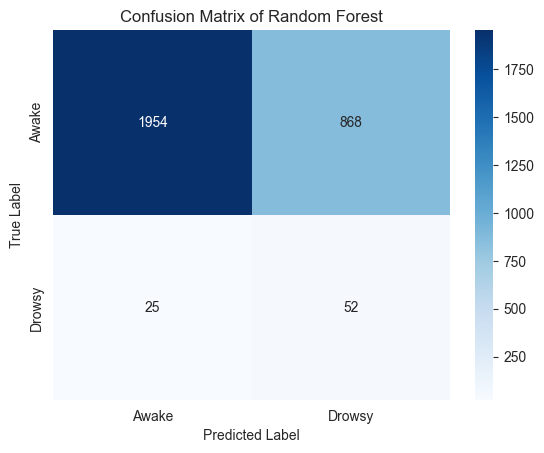

In [38]:
best_rf = grid_search.best_estimator_
confusion_matrix_on_test_data(best_rf, 'Random Forest', X_test, y_test)


In [16]:

# rf_classifier = RandomForestClassifier(n_estimators=500, criterion='entropy', oob_score=True,
#                                        max_features='sqrt', max_depth=10,
#                                        random_state=42)  # number of trees in the forest
# 
# n_splits = 10
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# plot_precision_recall(rf_classifier,X,y)

# plot_auc_roc(X_resampled, y_resampled, cv, rf_classifier, n_splits)
# plot_auc_roc(X_smote, y_smote, cv, rf_classifier, n_splits)

# plot_learning_curve(X_sum, y_sum, rf_classifier)



NameError: name 'plot_auc_roc' is not defined